In [1]:
import Pkg
Pkg.activate("./thesis")
# Pkg.add("Clustering")
# Pkg.add("CSV")
# Pkg.add("Compose")
# Pkg.add("Cairo")
# Pkg.add("Fontconfig")
# Pkg.add("DataFrames")
# Pkg.add("DataFramesMeta")
# Pkg.add("Dates")
# Pkg.add("Distances")
# Pkg.add("Distributions")
# Pkg.add("HypothesisTests")
# Pkg.add("Plots")
# Pkg.add("Statistics")
# Pkg.add("StatsBase")
# Pkg.add("StatsPlots");

  Activating project at `C:\Users\trist\Documents\MASc\julia-projects\thesis\thesis`


In [2]:
using Clustering
using CSV
using Compose, Cairo, Fontconfig
using ColorSchemes
using DataFrames
using DataFramesMeta
using Dates
using Distances
using Distributions
using HypothesisTests
using Plots
using Statistics
using StatsBase
using StatsPlots

# Load BCT data and save to csv

In [195]:
folder = joinpath(@__DIR__(), "data")
file_prefix = "BCT Victoria Data_"
suffixes = ["Sept 2023.csv", "Oct 2023.csv", "Nov 2023.csv", "Sept 2024.csv", "Oct 2024.csv", "Nov 2024.csv"]
historical_data = DataFrames.DataFrame(
    "Company Label" => String15[],
    "Route" => String3[],
    "Trip ID" => Int64[],
    "Date" => String15[],
    "Scheduled Trip Time" => String15[],
    "Scheduled Runtime in Seconds" => Int64[],
    "Trip Delay Departure in Seconds" => Int64[],
    "Actual Runtime in Seconds" => Int64[],
    "Trip End Delay in Seonds" => Int64[],
    "Route Class" => String15[],
    "Boardings" => Int64[],
    "Day Name" => String15[],
    "Direction Label" => String15[]
)
for suffix in suffixes
    historical_data = vcat(historical_data, CSV.read(joinpath(folder, file_prefix * suffix), DataFrames.DataFrame))
end
rename!(historical_data, [
        "Company Label" => :company,
        "Route" => :route,
        "Trip ID" => :trip_id,
        "Date" => :date,
        "Scheduled Trip Time" => :planned_start_time,
        "Scheduled Runtime in Seconds" => :planned_duration_seconds,
        "Trip Delay Departure in Seconds" => :start_delay_seconds,
        "Actual Runtime in Seconds" => :actual_duration_seconds,
        "Trip End Delay in Seonds" => :end_delay_seconds,
        "Route Class" => :route_class,
        "Boardings" => :total_boardings,
        "Day Name" => :day,
        "Direction Label" => :direction
    ])
function parse_time(time)
    time_str = strip(string(time))  # Remove any spaces

    # Extract AM/PM
    is_pm = occursin("PM", time_str)
    is_am = occursin("AM", time_str)
    
    # Remove AM/PM from string
    time_str = replace(time_str, r" ?(AM|PM)" => "")

    # Split into components
    parts = split(time_str, ":")
    hour = parse(Int, parts[1])  # Convert hour to integer
    second = round(Int, parse(Float32, parts[3]))

    # Convert to 24-hour format
    if is_pm && hour != 12
        hour += 12  # Convert PM hours (except 12 PM)
    elseif is_am && hour == 12
        hour = 0  # Convert 12 AM to 00
    end
    
    time_str = string(lpad(hour, 2, '0'), ":", parts[2], ":", lpad(second, 2, '0'))

    # Format the result with leading zeros
    return Time(time_str, dateformat"HH:MM:SS")
end
historical_data = filter(row -> !ismissing(row.route), historical_data)
historical_data.start_delay_seconds = coalesce.(historical_data.start_delay_seconds, 0)
historical_data.planned_start_time = parse_time.(historical_data.planned_start_time)
# CSV.write(joinpath(folder, "victoria_data.csv"), historical_data);

first(historical_data, 5)

5×13 DataFrame
 Row │ company    route     trip_id  date       planned_start_time  planned_du ⋯
     │ String15?  String3?  Int64?   String15?  Time                Int64?     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Victoria   1         2590067  9/1/2023   07:07:00                       ⋯
   2 │ Victoria   1         2590075  9/1/2023   15:14:00
   3 │ Victoria   1         2590079  9/1/2023   16:07:00
   4 │ Victoria   1         2590083  9/1/2023   16:47:00
   5 │ Victoria   1         2590069  9/1/2023   06:47:00                       ⋯
                                                               8 columns omitted

# QA

In [3]:
include("./src/utils.jl");

In [4]:
historical_data = loadHistoricalData("..\\data\\victoria_data.csv")
historical_data.route_dir = historical_data.route .* ":" .* historical_data.direction_code
historical_data.year = year.(historical_data.date);

In [207]:
first(historical_data, 5)

5×21 DataFrame
 Row │ company   route    trip_id  date        planned_start_time  planned_dur ⋯
     │ String15  String3  Int64    Date        Time                Int64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Victoria  1        2668745  2023-09-05  07:09:00                        ⋯
   2 │ Victoria  1        2669168  2023-09-05  07:45:00
   3 │ Victoria  1        2668753  2023-09-05  15:14:00
   4 │ Victoria  1        2668757  2023-09-05  16:07:00
   5 │ Victoria  1        2668761  2023-09-05  16:47:00                        ⋯
                                                              16 columns omitted

In [200]:
@show minimum(historical_data[year.(historical_data.date) .== 2023, :date])
@show maximum(historical_data[year.(historical_data.date) .== 2023, :date])
@show minimum(historical_data[year.(historical_data.date) .== 2024, :date])
@show maximum(historical_data[year.(historical_data.date) .== 2024, :date]);

minimum(historical_data[year.(historical_data.date) .== 2023, :date]) = Date("2023-09-05")
maximum(historical_data[year.(historical_data.date) .== 2023, :date]) = Date("2023-11-30")
minimum(historical_data[year.(historical_data.date) .== 2024, :date]) = Date("2024-09-03")
maximum(historical_data[year.(historical_data.date) .== 2024, :date]) = Date("2024-11-28")


In [45]:
ftn_routes = string.([4, 6, 11, 14, 15, 26, 27, 28, 30, 31])
ftn_df = historical_data[(in.(historical_data.route, Ref(ftn_routes))), :];

In [65]:
# route_time_direction_df = DataFrames.groupby(historical_data[historical_data.year .== 2024, :], [:route_dir, :hour_of_day]);
route_time_direction_df = DataFrames.groupby(ftn_df[ftn_df.year .== 2024, :], [:route_dir, :hour_of_day]);

In [66]:
combined_df = combine(
    route_time_direction_df,
    :total_boardings => mean => :ridership_μ,
    :total_boardings => std => :ridership_σ,
    :primary_delay_hours => mean => :primary_μ,
    :start_delay_seconds => mean => :secondary_μ,
    :primary_delay_hours => std => :primary_σ,
    :start_delay_seconds => std => :secondary_σ
)
# cor_df = unstack(combined_df, [:planned_start_hour, :direction], :route, :primary_μ);
cor_df = unstack(combined_df, :hour_of_day, :route_dir, :primary_μ)
cor_df = sort(cor_df, :hour_of_day);

In [67]:
first(cor_df, 5)

5×21 DataFrame
 Row │ hour_of_day  4:East        4:West       6:North      6:South       11:E ⋯
     │ Int64        Float64?      Float64?     Float64?     Float64?      Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │           5  -0.0601638    -0.00263533   0.0089245   -0.0207728    -0.0 ⋯
   2 │           6   0.000130579  -0.0230235    0.0117557   -0.000962644  -0.0
   3 │           7  -0.000330484  -0.00881588   0.021808    -0.0370954     0.0
   4 │           8  -0.0312279    -0.0279679    0.00976533  -0.0237596     0.0
   5 │           9   0.0180853     0.00455556  -0.0105342   -0.0298396     0.0 ⋯
                                                              16 columns omitted

In [68]:
# cor_mat = Matrix(cor_df[:, Not(:planned_start_hour, :direction)])
cor_mat = Matrix(cor_df[:, Not(:hour_of_day)])

# Function to compute correlation between two columns, skipping missing values
function safe_cor(x, y)
    mask = .!(ismissing.(x) .| ismissing.(y))
    if sum(mask) < 2
        return 0
    end
    return Statistics.cor(x[mask], y[mask])
end

# Compute the correlation matrix manually
n = size(cor_mat, 2)
corr_matrix = Array{Float64}(undef, n, n)
for i in 1:n
    for j in 1:n
        corr_matrix[i, j] = safe_cor(cor_mat[:, i], cor_mat[:, j])
    end
end
# setindex!.(Ref(corr_matrix), 0.0, 1:n, 1:n);

In [69]:
# Use Euclidean distance or another distance metric
dist_matrix = pairwise(Euclidean(), corr_matrix)

# Perform hierarchical clustering using the Ward method
hclust_result = hclust(dist_matrix, linkage=:ward)

# Get the order of clustering to reorder the rows/columns
cluster_order = hclust_result.order

# Reorder the correlation matrix according to the cluster order
reordered_corr_matrix = corr_matrix[cluster_order, cluster_order];

In [11]:
n_clusters = 10
clusters = cutree(hclust_result; k=n_clusters)
cluster_indices = []

for i in 1:n_clusters
    indices = findall(x -> x == i, clusters)
    sorted_indices = sort(indices, by=x -> findfirst(isequal(x), cluster_order))
    # println("Cluster $i: ", names(cor_df[:, Not(:planned_start_hour, :direction)])[sorted_indices])
    println("Cluster $i: ", names(cor_df[:, Not(:hour_of_day)])[sorted_indices])
    push!(cluster_indices, sorted_indices)
end

Cluster 1: ["32:North", "32:South", "31:North", "7:Counterclo", "15:East", "82:North", "1:East", "1:West", "64:East", "87:North"]
Cluster 2: ["61:West", "88:North", "30:South", "57:South", "8:West", "21:Clockwise", "12:West", "27:North", "55:Counterclo", "24:East", "70:South", "7N:Clockwise", "7N:Counterclo", "61:East", "75:North", "26A:West", "65:West", "65:East", "17:East", "17:West", "2:East", "54:Clockwise"]
Cluster 3: ["11:East", "75:South", "52:East", "56:North", "3:Clockwise", "3:Counterclo", "2:West", "22:South", "53:East", "12:East", "27:South"]
Cluster 4: ["83:South", "22A:South", "10:Counterclo", "95:West", "14:West", "26:West", "4:West", "15:West", "6B:North", "6B:South", "4:East", "31:South"]
Cluster 5: ["46:West", "26B:West", "24:West", "25:West", "5:East", "7:Clockwise", "39:West", "14:East", "28:North", "72:South", "21:Counterclo", "6:South", "52:West", "25:East", "39:East", "26:East", "72:North", "95:East", "85:Clockwise", "11:West", "28:South", "30:North", "10:Clockwi

In [31]:
names(cor_df[:, Not(:hour_of_day)])[sortperm(vec(corr_matrix[names(cor_df[:, Not(:hour_of_day)]) .== "75:South", :]))]

115-element Vector{String}:
 "47:East"
 "48:East"
 "48:West"
 "82:North"
 "7N:Counterclo"
 "63:West"
 "7N:Clockwise"
 "71:North"
 "1:East"
 "82:South"
 "1:West"
 "32:South"
 "71:South"
 ⋮
 "53:East"
 "59:Counterclo"
 "56:North"
 "22:South"
 "21:Counterclo"
 "55:Counterclo"
 "85:Clockwise"
 "43:Clockwise"
 "9:East"
 "9:West"
 "47:West"
 "75:South"

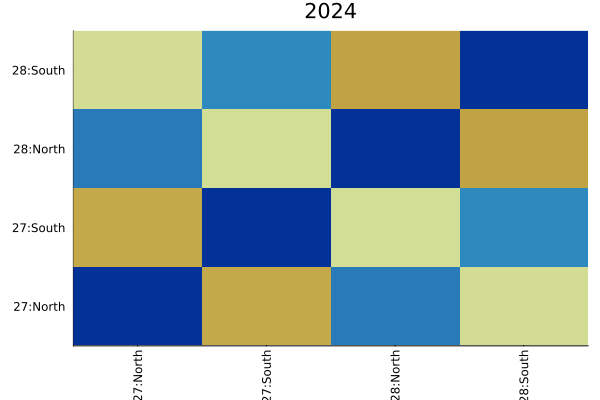

In [70]:
ind = 8
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:hour_of_day)]), ["70:true", "70:false", "71:true", "71:false", "72:true", "72:false"]))
custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:hour_of_day)]), ["27:North", "27:South", "28:North", "28:South"]))
# custom_indices = .!isnothing.(indexin(names(cor_df[:, Not(:hour_of_day)]), ["15:East", "15:West", "26:East", "26:West"]))

corr_heatmap_2024 = heatmap(
    # corr_matrix,
    # reordered_corr_matrix,
    # corr_matrix[vcat(cluster_indices...), vcat(cluster_indices...)],
    # corr_matrix[cluster_indices[ind], cluster_indices[ind]],
    corr_matrix[custom_indices, custom_indices],
    c=:roma,
    # xticks=(1:size(cluster_order,1), names(cor_df[:, Not(:hour_of_day)])),
    # xticks=(1:size(cluster_order,1), names(cor_df[:, Not(:hour_of_day)])[cluster_order]),
    # xticks=(1:size(cluster_indices[ind],1), names(cor_df[:, Not(:hour_of_day)])[cluster_indices[ind]]),
    # xticks=(1:size(vcat(cluster_indices...),1), names(cor_df[:, Not(:hour_of_day)])[vcat(cluster_indices...)]),
    xticks=(1:size(custom_indices,1), names(cor_df[:, Not(:hour_of_day)])[custom_indices]),
    xrot=90,
    # yticks=(1:size(cluster_order,1), names(cor_df[:, Not(:hour_of_day)])),
    # yticks=(1:size(cluster_order,1), names(cor_df[:, Not(:hour_of_day)])[cluster_order]),
    # yticks=(1:size(cluster_indices[ind],1), names(cor_df[:, Not(:hour_of_day)])[cluster_indices[ind]]),
    # yticks=(1:size(vcat(cluster_indices...),1), names(cor_df[:, Not(:hour_of_day)])[vcat(cluster_indices...)]),
    yticks=(1:size(custom_indices,1), names(cor_df[:, Not(:hour_of_day)])[custom_indices]),
    # yticks=nothing,
    title="2024",
    # size=(800, 600),
    clims=(-1,1),
    # xtickfontsize=4,
    # ytickfontsize=4,
    legend=false
)
# savefig(corr_heatmap, "imgs\\weekday_primary_delay_correlations.png")

In [73]:
cbar = heatmap(
    rand(2,2),
    clims=(-1, 1),
    framestyle=:none,
    c=cgrad(ColorSchemes.roma),
    cbar=true,
    lims=(-1,0)
)
empty_plot = plot(legend=false, grid=false, foreground_color_subplot=:white)
corr_heatmap = plot(empty_plot, corr_heatmap_2023, corr_heatmap_2024, cbar,
    layout=(@layout [a{0.05w} [b{0.9w, 0.5h}; c{0.9w, 0.5h}] d{0.05w}]), size=(900, 1200))
# savefig(corr_heatmap, "imgs\\27-28_weekday_primary_delay_correlations.png")

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [52]:
route_tuples = findall((corr_matrix .< 1) .& (corr_matrix .> 0.90))
for (r1, r2) in Tuple.(route_tuples)
    println(names(cor_df)[r1+2], " ", names(cor_df)[r2+2])
end

82 1
43 3
43 4
52 9
61 9
95 9
65 11
63 14
95 17
43 21
82 21
47 22
63 24
65 24
63 25
65 26
64 32
60 35
82 35
85 35
63 39
3 43
4 43
21 43
85 43
82 46
22 47
56 48
65 48
82 48
88 51
9 52
65 52
82 52
82 53
48 56
64 58
82 58
82 59
35 60
9 61
14 63
24 63
25 63
39 63
72 63
81 63
32 64
58 64
87 64
11 65
24 65
26 65
48 65
52 65
75 65
72 71
63 72
71 72
65 75
63 81
1 82
21 82
35 82
46 82
48 82
52 82
53 82
58 82
59 82
35 85
43 85
64 87
51 88
9 95
17 95


In [74]:
p1 = historical_data[(historical_data.year .== 2023) .& (rte in ["27", "28"] for rte in historical_data.route), :primary_delay_hours] .* 60
s1 = historical_data[(historical_data.year .== 2023) .& (rte in ["27", "28"] for rte in historical_data.route), :start_delay_seconds] ./ 60
p2 = historical_data[(historical_data.year .== 2024) .& (rte in ["27", "28"] for rte in historical_data.route), :primary_delay_hours] .* 60
s2 = historical_data[(historical_data.year .== 2024) .& (rte in ["27", "28"] for rte in historical_data.route), :start_delay_seconds] ./ 60
# p1 = historical_data[(historical_data.year .== 2023) .& coalesce.(historical_data.route_class .== "FTN", false), :primary_delay_hours] .* 60
# s1 = historical_data[(historical_data.year .== 2023) .& coalesce.(historical_data.route_class .== "FTN", false), :start_delay_seconds] ./ 60
# p2 = historical_data[(historical_data.year .== 2024) .& coalesce.(historical_data.route_class .== "FTN", false), :primary_delay_hours] .* 60
# s2 = historical_data[(historical_data.year .== 2024) .& coalesce.(historical_data.route_class .== "FTN", false), :start_delay_seconds] ./ 60
@show mean(p1), std(p1)
@show mean(p2), std(p2);

(mean(p1), std(p1)) = (-0.07003164974284583, 4.568552683691496)
(mean(p2), std(p2)) = (-0.7989755509641873, 5.932001507276937)


In [75]:
# nanaimo_hist = histogram(
#     [nx ny],
#     bins=range(-15, 15, length=31),
#     normalize=true,
#     label=["primary" "secondary"],
#     alpha=0.5,
#     xlabel="minutes",
#     ylabel="percent (%)",
#     title="Nanaimo weekday delays",
# )
victoria_hist = histogram(
    p1,
    bins=range(-20, 20, length=33),
    normalize=true,
    label="2023",
    alpha=0.5,
    xlabel="minutes",
    ylabel="normalized density",
    title="Primary delay distribution",
    size=(800, 600)
)
histogram!(
    p2,
    bins=range(-20, 20, length=33),
    normalize=true,
    label="2024",
    alpha=0.5,
    size=(800, 600)
)
# histplot = plot(nanaimo_hist, victoria_hist,  layout=(1, 2), link=:y, size=(750, 450))
# savefig(victoria_hist, "imgs\\weekday_delay_histogram.png")

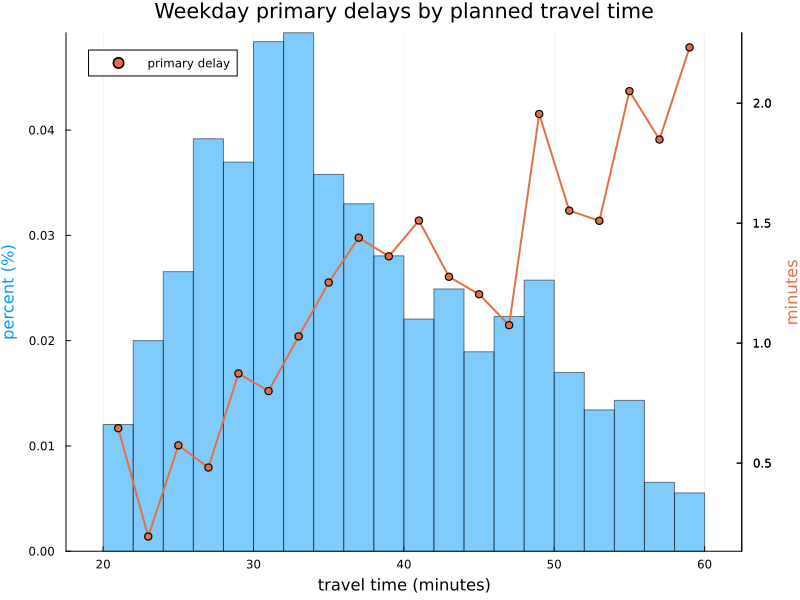

In [22]:
# travel_time_hist = histogram(
#     nanaimo_wkdy.planned_duration_seconds ./ 60,
#     bins=range(0, 80, length=21),
#     normalize=true,
#     label="nanaimo",
#     alpha=0.5,
#     xlabel="minutes",
#     ylabel="percent (%)",
#     title="Weekday travel times",
# )
planned_durations = victoria_wkdy.planned_duration_seconds ./ 60
primary_delays = victoria_wkdy.primary_delay_seconds ./ 60

bin_edges = range(20, 60, length=21)
bin_centers = collect(midpoints(bin_edges))

bin_indices = fit(Histogram, planned_durations, bin_edges, closed=:left).weights
binned_delay_means = [mean(primary_delays[planned_durations .>= bin_edges[i] .&& planned_durations .< bin_edges[i+1]]) for i in 1:length(bin_edges)-1]

travel_time_hist = histogram(
    planned_durations,
    bins=bin_edges,
    normalize=true,
    label="",
    xlabel="travel time (minutes)",
    ylabel="percent (%)",
    yguidefontcolor=palette(:default)[1],
    alpha=0.5,
    title="Weekday primary delays by planned travel time",
    size=(800,600)
)
plot!(
    twinx(),
    bin_centers,
    binned_delay_means,
    seriestype=:line,
    label="",
    color=palette(:default)[2],
    yguidefontcolor=palette(:default)[2],
    lw=2,
    ylabel="minutes"
)
plot!(
    twinx(),
    bin_centers,
    binned_delay_means,
    seriestype=:scatter,
    label="primary delay",
    color=palette(:default)[2],
    lw=2,
    legend=:topleft
)
# savefig(travel_time_hist, "imgs\\weekday_travel_time_histogram_victoria.png")

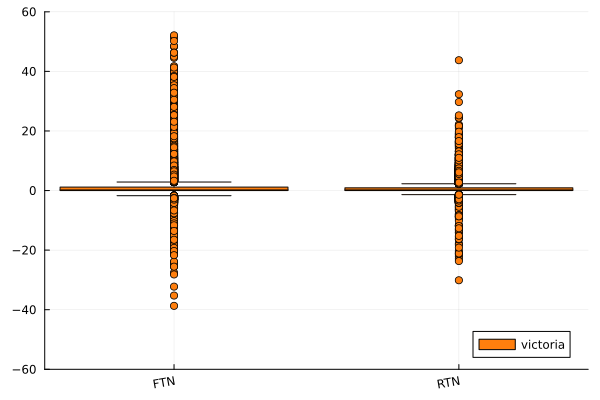

In [198]:
# nanaimo_box = @df nanaimo_wkdy[.!ismissing.(nanaimo_wkdy.route_class), :] boxplot(
#     :route_class,
#     :start_delay_seconds ./ 60,
#     ylims=(-60, 60),
#     label="nanaimo",
#     ylabel="minutes",
#     xrotation=10,
# )
victoria_box = @df ftn_df boxplot(
    :route_class,
    :start_delay_seconds ./ 60,
    ylims=(-60, 60),
    color=palette(:tab10)[2],
    label="victoria",
    xrotation=10,
)
# plotbox = plot(nanaimo_box, victoria_box,  layout=(1, 2), link=:y, size=(750, 450), title="Weekday secondary delays")
# savefig(plotbox, "imgs\\weekday_sdelay_box.png")

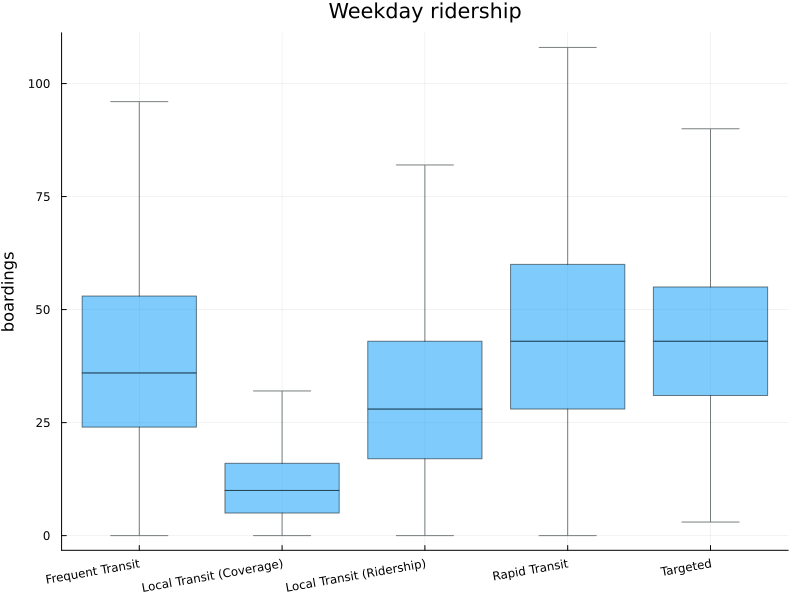

In [21]:
# ridership_violin = @df nanaimo_wkdy[.!ismissing.(nanaimo_wkdy.route_class), :] violin(
#     :route_class,
#     :total_boardings,
#     side=:left,
#     label="nanaimo",
#     ylabel="boardings",
#     xrotation=10,
#     title="Weekday ridership"
# )
# @df victoria_wkdy[(.!ismissing.(victoria_wkdy.route_class)) .& (victoria_wkdy.route_class .!= "Rapid Transit"), :] violin(
ridership_boxplot = @df victoria_wkdy[.!ismissing.(victoria_wkdy.route_class), :] boxplot(
    :route_class,
    :total_boardings,
    # side=:right,
    outliers=false,
    alpha=0.5,
    label="",
    ylabel="boardings",
    xrotation=10,
    title="Weekday ridership",
    size=(800, 600)
)
# savefig(ridership_boxplot, "imgs\\weekday_ridership_boxplot_victoria.png")

In [248]:
ftn_df.primary_passenger_delay = max.(ftn_df.primary_delay_hours .* ftn_df.total_boardings, 0)
ftn_df.route_dir = string.(ftn_df.route, ":", ftn_df.direction_code)
first(ftn_df, 5)

5×22 DataFrame
 Row │ company   route    trip_id  date        planned_start_time  planned_dur ⋯
     │ String15  String3  Int64    Date        Time                Int64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Victoria  4        2669420  2023-09-05  00:13:00                        ⋯
   2 │ Victoria  4        2669309  2023-09-05  05:56:00
   3 │ Victoria  4        2669295  2023-09-05  06:19:00
   4 │ Victoria  4        2669311  2023-09-05  06:41:00
   5 │ Victoria  4        2669305  2023-09-05  07:01:00                        ⋯
                                                              17 columns omitted

In [249]:
victoria_grouped_2023 = DataFrames.groupby(
    ftn_df[(ftn_df.year .== 2023), :],
    :hour_of_day
)
victoria_grouped_2024 = DataFrames.groupby(
    ftn_df[(ftn_df.year .== 2024), :],
    :hour_of_day
)

q25 = x -> quantile(x, 0.25)
q50 = x -> quantile(x, 0.5)
q75 = x -> quantile(x, 0.75)

victoria_combined_2023 = combine(
    victoria_grouped_2023,
    :total_boardings => mean => :ridership_μ,
    :total_boardings => std => :ridership_σ,
    :total_boardings => q25 => :ridership_q25,
    :total_boardings => q50 => :ridership_q50,
    :total_boardings => q75 => :ridership_q75,
    :end_delay_seconds => mean => :end_delay_μ,
    :end_delay_seconds => std => :end_delay_σ,
    :end_delay_seconds => q25 => :end_delay_q25,
    :end_delay_seconds => q50 => :end_delay_q50,
    :end_delay_seconds => q75 => :end_delay_q75,
    :primary_delay_hours => mean => :primary_μ,
    :primary_passenger_delay => mean => :passenger_μ,
    :primary_delay_hours => std => :primary_σ,
    :primary_passenger_delay => std => :passenger_σ,
    :primary_delay_hours => q25 => :primary_q25,
    :primary_delay_hours => q50 => :primary_q50,
    :primary_delay_hours => q75 => :primary_q75,
    :primary_passenger_delay => q25 => :passenger_q25,
    :primary_passenger_delay => q50 => :passenger_q50,
    :primary_passenger_delay => q75 => :passenger_q75
)
victoria_combined_2024 = combine(
    victoria_grouped_2024,
    :total_boardings => mean => :ridership_μ,
    :total_boardings => std => :ridership_σ,
    :total_boardings => q25 => :ridership_q25,
    :total_boardings => q50 => :ridership_q50,
    :total_boardings => q75 => :ridership_q75,
    :end_delay_seconds => mean => :end_delay_μ,
    :end_delay_seconds => std => :end_delay_σ,
    :end_delay_seconds => q25 => :end_delay_q25,
    :end_delay_seconds => q50 => :end_delay_q50,
    :end_delay_seconds => q75 => :end_delay_q75,
    :primary_delay_hours => mean => :primary_μ,
    :primary_passenger_delay => mean => :passenger_μ,
    :primary_delay_hours => std => :primary_σ,
    :primary_passenger_delay => std => :passenger_σ,
    :primary_delay_hours => q25 => :primary_q25,
    :primary_delay_hours => q50 => :primary_q50,
    :primary_delay_hours => q75 => :primary_q75,
    :primary_passenger_delay => q25 => :passenger_q25,
    :primary_passenger_delay => q50 => :passenger_q50,
    :primary_passenger_delay => q75 => :passenger_q75
);

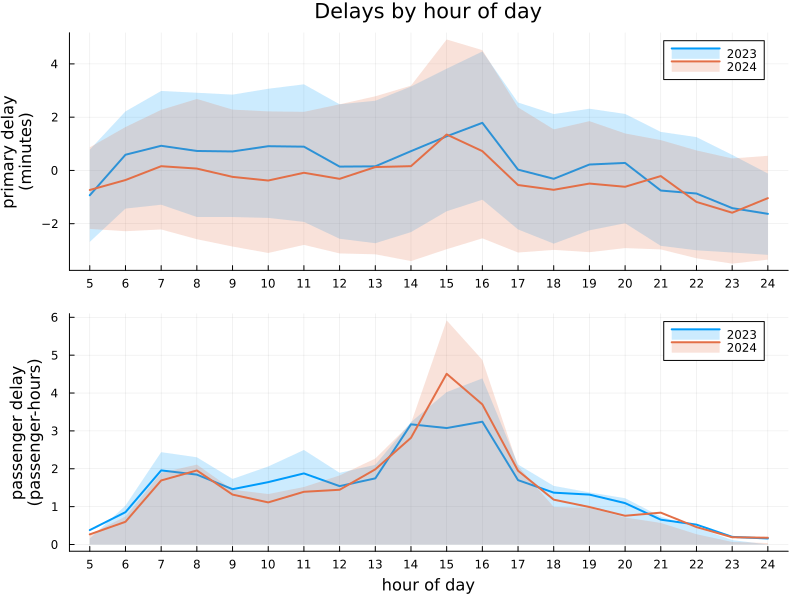

In [250]:
hourly_delay_plot = @df victoria_combined_2023 plot(
    :hour_of_day,
    :primary_μ .* 60,
    fillrange=(:primary_q25 .* 60, :primary_q75 .* 60),
    label="2023",
    lw=2,
    fillalpha=0.2,
    xticks=5:24,
    ylabel="primary delay\n(minutes)",
    title="Delays by hour of day",
    size=(800, 600)
)
@df victoria_combined_2024 plot!(
    hourly_delay_plot,
    :hour_of_day,
    :primary_μ .* 60,
    fillrange=(:primary_q25 .* 60, :primary_q75 .* 60),
    label="2024",
    lw=2,
    fillalpha=0.2,
    size=(800, 600)
)
hourly_passenger_delay_plot = @df victoria_combined_2023 plot(
    :hour_of_day,
    :passenger_μ,
    fillrange=(:passenger_q25, :passenger_q75),
    label="2023",
    lw=2,
    fillalpha=0.2,
    xlabel="hour of day",
    xticks=5:24,
    ylabel="passenger delay\n(passenger-hours)",
    size=(800, 600)
)
@df victoria_combined_2024 plot!(
    hourly_passenger_delay_plot,
    :hour_of_day,
    :passenger_μ,
    fillrange=(:passenger_q25, :passenger_q75),
    label="2024",
    lw=2,
    fillalpha=0.2,
    size=(800, 600)
)
delay_plot = plot(hourly_delay_plot, hourly_passenger_delay_plot, layout=(@layout [a; b]), link=:x)
# savefig(delay_plot, "imgs\\weekday_delay_by_hour.png")

In [69]:
trips, shapes = loadGTFS("..\\data\\Victoria-GTFS", historical_data);

In [195]:
route_class_dict = Dict(
    row.route => row.route_class for row in eachrow(unique(historical_data, [:route, :route_class]))
)
trips.route_class = [route in keys(route_class_dict) ? route_class_dict[route] : nothing for route in trips.route_id]
combine(groupby(trips, :route_class), nrow => :trip_count)
# combine(groupby(trips[[rid in [4, 6, 14, 15, 26, 27, 28, 95] for rid in trips.route_id], :], :route_id), nrow => :trip_count)
# sort(combine(groupby(trips, :trip_id), nrow => :trip_count), :trip_count)
# first(trips, 5)

6×2 DataFrame
 Row │ route_class                trip_count 
     │ Union…                     Int64      
─────┼───────────────────────────────────────
   1 │ Local Transit (Ridership)         983
   2 │ Frequent Transit                 1137
   3 │ Rapid Transit                     376
   4 │ Local Transit (Coverage)          453
   5 │                                   117
   6 │ Targeted                           42

In [239]:
# unique(historical_data[ismissing.(historical_data.route_class), :route])
historical_data[[rte ∈ ["26A", "26B", "6A", "6B", "27X", "28X"] for rte in historical_data.route], :route_class] .= "FTN"

8928-element view(::PooledArrays.PooledVector{Union{Missing, String15}, UInt32, Vector{UInt32}}, [2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907  …  235914, 235915, 235916, 235917, 235918, 235919, 235920, 235921, 235922, 235923]) with eltype Union{Missing, String15}:
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 ⋮
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"
 "FTN"

In [240]:
historical_data_grouped = DataFrames.groupby(historical_data, [:year, :date, :route_class])
historical_data_combined = combine(
    historical_data_grouped,
    nrow => :trip_count,
    :total_boardings => sum => :total_boardings,
    :primary_delay_hours => x -> sum(x[x .> 0])
)

historical_data_grouped = DataFrames.groupby(historical_data_combined, [:year, :route_class])
historical_data_combined = combine(
    historical_data_grouped,
    :trip_count => mean => :avg_trip_count,
    :total_boardings => mean => :avg_total_boardings,
    :primary_delay_hours_function => mean => :avg_total_delay
)
sort(historical_data_combined, [:route_class])

12×5 DataFrame
 Row │ year   route_class  avg_trip_count  avg_total_boardings  avg_total_dela ⋯
     │ Int64  String15?    Float64         Float64              Float64        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023  FTN               1287.67              53543.4          39.4734  ⋯
   2 │  2024  FTN               1271.05              53511.9          36.9796
   3 │  2023  LTN-C              533.436              7220.54         14.6203
   4 │  2024  LTN-C              606.974              8558.38         13.6435
   5 │  2023  LTN-R              887.487             30313.9          30.4866  ⋯
   6 │  2024  LTN-R              860.974             31382.3          33.4872
   7 │  2023  RTN                221.231             11585.5           5.64915
   8 │  2024  RTN                214.692             12490.9           7.02139
   9 │  2023  Targeted            41.7692             1892.18          1.13348 ⋯
  10 │  2024  Targeted            41.641              1882.26          3.38687
  11 │  2023  missing             26.7692              558.59          0.64582
  12 │  2024  missing             55.9487              957.641         1.35413
                                                                1 column omitted

In [193]:
historical_data_grouped = DataFrames.groupby(
    historical_data[coalesce.(historical_data.route_class .== "FTN", false), :],
    [:date, :hour_of_day]
)
historical_data_combined = combine(
    historical_data_grouped,
    nrow => :trip_count,
    :total_boardings => mean => :avg_total_boardings,
    :primary_passenger_delay => mean => :avg_primary_passenger_delay
)

historical_data_grouped = DataFrames.groupby(historical_data_combined, [:hour_of_day])
historical_data_combined = combine(
    historical_data_grouped,
    :trip_count => mean => :avg_trip_count,
    :avg_total_boardings => mean => :avg_total_boardings,
    :avg_primary_passenger_delay => mean => :avg_primary_passenger_delay
)
# bar(
#     historical_data_combined.hour_of_day,
#     historical_data_combined.avg_trip_count,
#     label="",
#     xlabel="hour",
#     xticks=[4, 8, 12, 16, 20, 24],
#     ylabel="trip count",
#     title="Weekday trip counts",
#     size=(800, 600)
# )

20×4 DataFrame
 Row │ hour_of_day  avg_trip_count  avg_total_boardings  avg_primary_passenger ⋯
     │ Int64        Float64         Float64              Float64               ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │           5         18.3462             18.6869                      0. ⋯
   2 │           6         50.1282             28.1506                      0.
   3 │           7         75.5385             46.1822                      1.
   4 │           8         68.9744             47.4731                      1.
   5 │           9         68.7949             36.3457                      1. ⋯
   6 │          10         55.6538             37.6127                      1.
   7 │          11         56.5641             42.319                       1.
   8 │          12         56.2821             43.2764                      1.
   9 │          13         54.7436             47.1393                      1. ⋯
  10 │          14         65.2179             61.1771                      3.
  11 │          15         67.0897             64.8338                      3.
  12 │          16         65.3846             59.572                       3.
  13 │          17         57.8718             48.7554                      1. ⋯
  14 │          18         54.1923             41.4892                      1.
  15 │          19         46.6795             34.1633                      1.
  16 │          20         38.3846             33.1943                      0.
  17 │          21         35.8846             29.1918                      0. ⋯
  18 │          22         31.9615             22.0897                      0.
  19 │          23         29.0                13.473                       0.
  20 │          24         17.5                 7.01026                     0.
                                                                1 column omitted

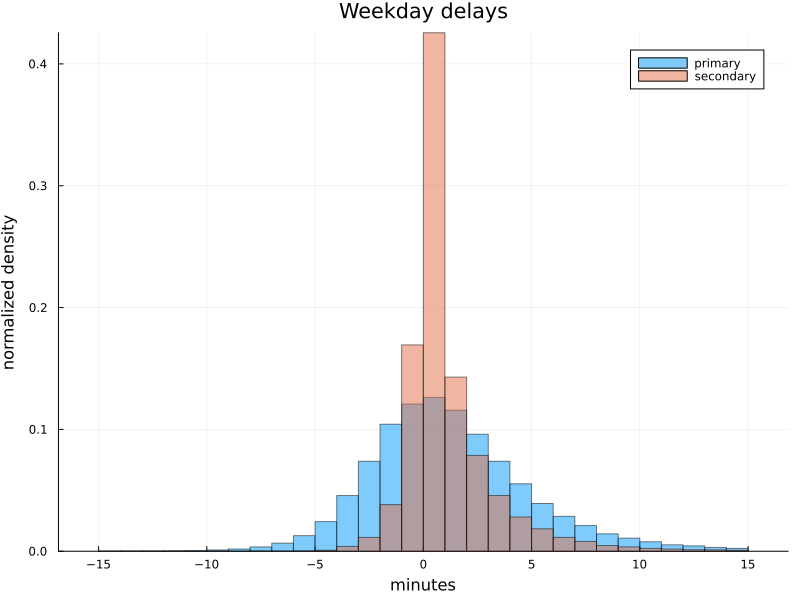

In [137]:
vx = historical_data.primary_delay_hours .* 60
vy = historical_data.start_delay_seconds ./ 60
victoria_hist = histogram(
    [vx vy],
    bins=range(-15, 15, length=31),
    normalize=true,
    label=["primary" "secondary"],
    alpha=0.5,
    xlabel="minutes",
    ylabel="normalized density",
    title="Weekday delays",
    size=(800, 600)
)
# savefig(victoria_hist, "imgs\\weekday_delay_histogram.png")

In [138]:
@show mean(vx)
@show std(vx)
@show mean(vy)
@show std(vy)

mean(vx) = 1.3524963522287883
std(vx) = 4.17194207345005
mean(vy) = 1.0962752608156416
std(vy) = 2.552193105047651


2.552193105047651

In [82]:
historical_data_grouped = DataFrames.groupby(historical_data[coalesce.(historical_data.route_class .== "FTN", false), :], [:year, :route])

q25 = x -> quantile(x, 0.25)
q50 = x -> quantile(x, 0.5)
q75 = x -> quantile(x, 0.75)

historical_data_combined = combine(
    historical_data_grouped,
    nrow => :trip_count,
    :primary_passenger_delay => mean => :passenger_delay_μ,
    :primary_passenger_delay => std => :passenger_delay_σ,
    :primary_passenger_delay => q25 => :passenger_delay_q25,
    :primary_passenger_delay => q50 => :passenger_delay_q50,
    :primary_passenger_delay => q75 => :passenger_delay_q75
);

In [83]:
# sort(historical_data_combined[historical_data_combined.trip_count .> 2000, :], :passenger_delay_μ, rev=true)
sort(historical_data_combined, :route)

18×8 DataFrame
 Row │ year   route    trip_count  passenger_delay_μ  passenger_delay_σ  passe ⋯
     │ Int64  String3  Int64       Float64            Float64            Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023  11             4391           1.99462             4.00299        ⋯
   2 │  2024  11             3748           2.30918             5.5685
   3 │  2023  14             6601           2.89663             5.44359
   4 │  2024  14             6719           2.27909             4.95071
   5 │  2023  26             5767           3.15656             6.01686        ⋯
   6 │  2024  26             6071           2.29445             5.99659
   7 │  2023  27             3852           1.28171             2.64607
   8 │  2024  27             4202           1.4508              3.81363
   9 │  2023  28             3731           1.32417             2.50264        ⋯
  10 │  2024  28             3542           1.03645             2.86635
  11 │  2023  30             2644           0.717766            1.54518
  12 │  2024  30             2629           0.80732             4.39146
  13 │  2023  31             2665           0.84085             2.44781        ⋯
  14 │  2024  31             2671           0.843588            2.09081
  15 │  2023  4              6236           1.06625             2.45507
  16 │  2024  4              5830           1.16619             2.88549
  17 │  2023  6              3892           0.861126            2.03245        ⋯
  18 │  2024  6              3916           0.769584            2.03607
                                                               3 columns omitted